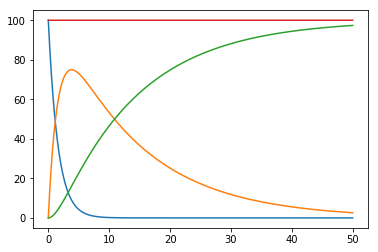

In [100]:
import math
import csv
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

#The input format is a comma separated list, where each value has its own row
csv_arr = []

#Currently the values are in minutes, this may change later on
with open('input_file.csv') as csv_in:
  filereader = csv.reader(csv_in)
  for row in filereader:
    csv_arr.append(row[0])

#The lambda values are input into the file precalculated from half-life
a_lambda = float(csv_arr[0])
b_lambda = float(csv_arr[1])

#The initial values
parent_init = float(csv_arr[2])
daughter_init = float(csv_arr[3])
stable_init = float(csv_arr[4])

#The delta t value
delta = float(csv_arr[5])

#The endtime
endtime = float(csv_arr[6])

#The constant production rate for both daughters
daughter_q = (parent_init * a_lambda) / (b_lambda - a_lambda)
stable_q = (parent_init/(b_lambda - a_lambda))

#The rest of this block of code is the analytical solution

#This is the x axis for the analytical solution
x = np.arange(0, endtime, .016667) 

#This calculates decay of the parent
def parent_decay(time): 
  return parent_init*(np.exp(-(a_lambda*time)))

#This was originally y, and parent is defined elsewhere, so I renamed it mother to keep meaning but make it distinct
mother = parent_decay(x)

#Calculates both the decay and growth of the first daughter
def daughter_decay(time):
  return daughter_init*(np.exp(-b_lambda*time)) + daughter_q * (np.exp(-a_lambda*time) - np.exp(-b_lambda*time))

first_daughter = daughter_decay(x)

#Calculates the growth of the third daughter
def stable_growth(time):
  return stable_init + daughter_init*(1 - np.exp(-b_lambda*time)) + stable_q * (b_lambda * (1 - np.exp(-a_lambda * time)) - a_lambda * (1 - np.exp(-b_lambda * time)))

second_daughter = stable_growth(x)

total_amount = np.add(np.add(mother, first_daughter), second_daughter)

plt.plot(x,mother)
plt.plot(x,first_daughter)
plt.plot(x,second_daughter)
plt.plot(x,total_amount)

In [122]:
#This block is for the numerical solutions

#This takes the delta T and provides an array of values numerically
def num_parent_decay(shift):
    jump = int(endtime/shift)
    time_step = np.linspace(0, endtime, num=jump)
    parent_amounts = [100.0]
    for i in time_step:
        value = -(a_lambda*shift*parent_decay(i))+parent_decay(i)
        """Since we know the that the form of decay is exponential, the derivative is the lambda
            times the function of decay. This is true for all the involved isotopes"""        
        parent_amounts.append(value)
    return parent_amounts

def num_daughter_decay(shift):
    jump = int(endtime/shift)
    time_step = np.linspace(0, endtime, num=jump)
    daughter_amounts = [0]
    for i in time_step:
        value = shift*(-(b_lambda*daughter_decay(i))+(a_lambda*parent_decay(i)))+daughter_decay(i)
        daughter_amounts.append(value)
    return daughter_amounts

def num_stable_growth(shift):
    jump = int(endtime/shift)
    time_step = np.linspace(0, endtime, num=jump)
    stable_amounts = [0]
    for i in time_step:
        value = b_lambda*shift*daughter_decay(i)+stable_growth(i)
        stable_amounts.append(value)
    return stable_amounts

def num_total(shift):
    parent = num_parent_decay(shift)
    first_daughter = num_daughter_decay(shift)
    second_daughter = num_stable_growth(shift)
    total_amounts = []
    for i in range(len(parent)):
        total_amounts.append(0)
    for i in range(len(parent)):
        value = parent[i]+first_daughter[i]+second_daughter[i]
        total_amounts[i] = value
    return total_amounts

def max_daughter(shift):
    changed = shift/64 #I really didn't want to change what I put in my input file
    one_over_time = []
    time_of_max = []
    for i in range(8):
        one_over_time.append(1/changed)
        time_of_max.append(num_daughter_decay(changed).index(max(num_daughter_decay(changed)))*changed)
        changed = changed*2
    return (one_over_time,time_of_max)
    
over_deltat,max_time = max_daughter(delta)

fine = delta/2
#for the graph of several numeric values, I use the fine delta t
numeric_parent = num_parent_decay(fine)
numeric_first_daughter = num_daughter_decay(fine) 
numeric_second_daughter = num_stable_growth(fine)
numeric_total = num_total(fine)
ree = int(endtime/fine)+1
numeric_fine_axis = np.linspace(0, endtime, ree)

numeric_first_medium = num_daughter_decay(delta)
see = int(endtime/delta)+1
numeric_medium_axis = np.linspace(0, endtime, see)

coarse = delta*1.5
numeric_first_coarse = num_daughter_decay(coarse)
vee = int(endtime/coarse)+1
numeric_coarse_axis = np.linspace(0, endtime, vee)


with open('output_file.csv', mode='w') as output_file:
    filewriter = csv.writer(output_file, delimiter=',', lineterminator='\n', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow([a_lambda])
    filewriter.writerow([b_lambda])
    filewriter.writerow([parent_init])
    filewriter.writerow([daughter_init])
    filewriter.writerow([stable_init])
    filewriter.writerow([delta])
    filewriter.writerow([endtime])
    filewriter.writerow(x)
    filewriter.writerow(mother)
    filewriter.writerow(first_daughter)
    filewriter.writerow(second_daughter)
    filewriter.writerow(total_amount)
    filewriter.writerow(numeric_parent)
    filewriter.writerow(numeric_first_daughter)
    filewriter.writerow(numeric_second_daughter)
    filewriter.writerow(numeric_total)
    filewriter.writerow(numeric_fine_axis)
    filewriter.writerow(numeric_first_medium)
    filewriter.writerow(numeric_medium_axis)
    filewriter.writerow(numeric_first_coarse)
    filewriter.writerow(numeric_coarse_axis)
    filewriter.writerow(max_time)
    filewriter.writerow(over_deltat)